In [2]:
import numpy as np
import matplotlib.pyplot as plt


class ucb_bandit:
    '''
    Upper Confidence Bound k-bandit problem
     
    Inputs 
    ============================================
    k: number of arms (int)
    c:
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    def __init__(self, k, c, iters, mu='random'):
        # Number of arms
        self.k = k
        # Exploration parameter
        self.c = c
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k - 1, k)

    def pull(self):
        # Select action according to UCB Criteria
        a = np.argmax(self.k_reward +
                      self.c * np.sqrt((np.log(self.n)) / self.k_n))

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward -
                                               self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward -
                                               self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

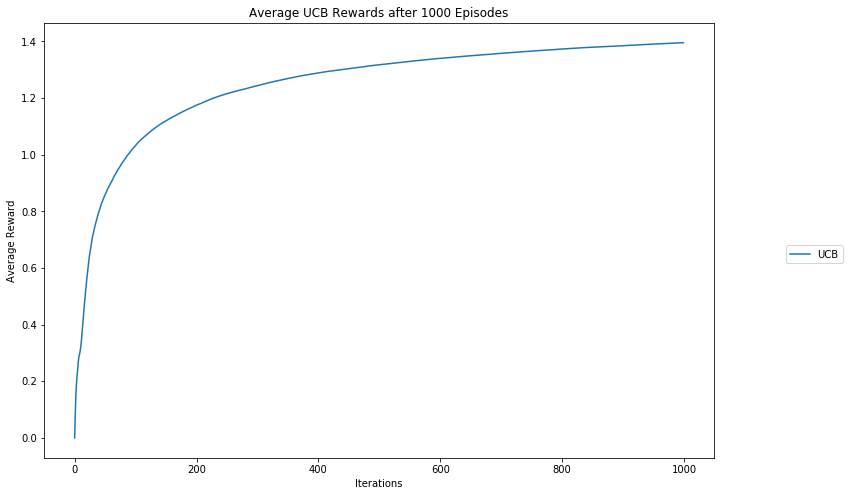

In [3]:
k = 10
iters = 1000
 
ucb_rewards = np.zeros(iters)
# Initialize bandits
ucb = ucb_bandit(k, 2, iters)
 
episodes = 1000
# Run experiments
for i in range(episodes): 
    ucb.reset('random')
    # Run experiments
    ucb.run()
     
    # Update long-term averages
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)
     
plt.figure(figsize=(12,8))
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average UCB Rewards after "
          + str(episodes) + " Episodes")
plt.show()

In [4]:
def softmax(x):
    return np.exp(x - x.max()) / np.sum(np.exp(x - x.max()), axis=0)

In [7]:
class grad_bandit:
    def __init__(self, k, alpha, iters, mu='random'):
        # Number of arms
        self.k = k
        self.actions = np.arange(k)
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        # Initialize preferences
        self.H = np.zeros(k)
        # Learning rate
        self.alpha = alpha

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k - 1, k)

    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) / np.sum(
            np.exp(self.H - np.max(self.H)), axis=0)

    def pull(self):
        # Update probabilities
        self.softmax()
        # Select highest preference action
        a = np.random.choice(self.actions, p=self.prob_action)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward -
                                               self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward -
                                               self.k_reward[a]) / self.k_n[a]

        # Update preferences
        self.H[a] = self.H[a] + self.alpha * (reward - self.mean_reward) * (
            1 - self.prob_action[a])
        actions_not_taken = self.actions != a
        self.H[actions_not_taken] = self.H[actions_not_taken] - self.alpha * (
            reward - self.mean_reward) * self.prob_action[actions_not_taken]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

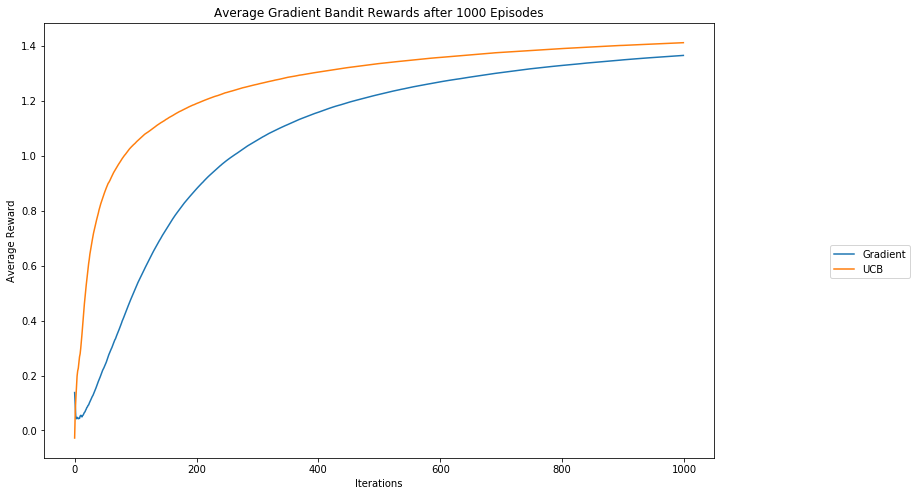

In [8]:
k = 10
iters = 1000
# Initialize bandits
grad = grad_bandit(k, 0.1, iters, mu='random')
ucb = ucb_bandit(k, 2, iters, mu=grad.mu)
ucb.mu = grad.mu
 
ucb_rewards = np.zeros(iters)
grad_rewards = np.zeros(iters)
opt_grad = 0
opt_ucb = 0
 
episodes = 1000
# Run experiments
for i in range(episodes):
    # Reset counts and rewards
    grad.reset('random')
    ucb.reset()
    ucb.mu = grad.mu
     
    # Run experiments
    grad.run()
    ucb.run()
     
    # Update long-term averages
    grad_rewards = grad_rewards + (
        grad.reward - grad_rewards) / (i + 1)
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)
     
    # Count optimal actions
    opt_grad += grad.k_n[np.argmax(grad.mu)]
    opt_ucb += ucb.k_n[np.argmax(ucb.mu)]
     
plt.figure(figsize=(12,8))
plt.plot(grad_rewards, label="Gradient")
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Gradient Bandit Rewards after "
          + str(episodes) + " Episodes")
plt.show()

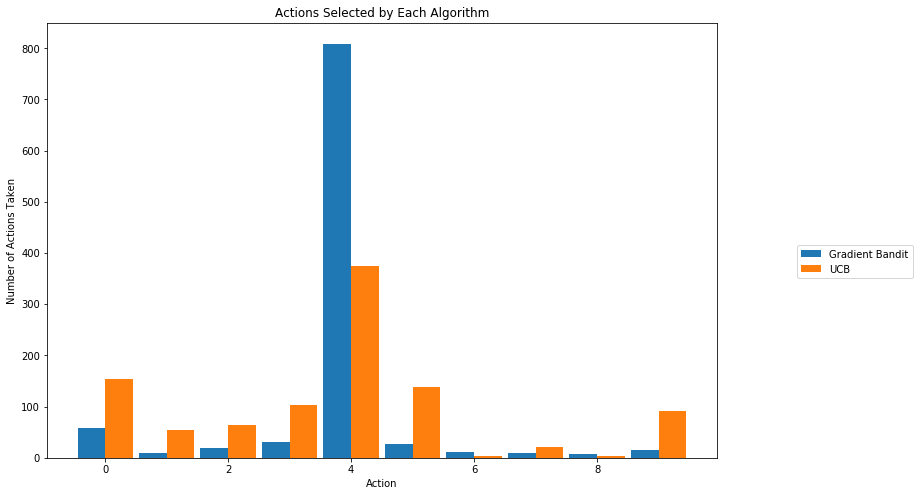

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
Grad,5.90,1.00,2.00,3.0,80.90,2.60,1.20,1.00,0.80,1.60
UCB,15.30,5.50,6.40,10.4,37.50,13.80,0.40,2.10,0.40,9.20
Expected Reward,1.04,0.47,0.86,0.9,0.99,0.77,-1.15,0.29,-1.11,0.61


In [9]:
import pandas as pd
width = 0.45
bins = np.linspace(0, k-1, k) - width/2
 
plt.figure(figsize=(12,8))
plt.bar(bins, grad.k_n,
        width=width, 
        label="Gradient Bandit")
plt.bar(bins+0.45, ucb.k_n,
        width=width, 
        label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()
 
opt_per = np.array([grad.k_n, ucb.k_n]) / iters * 100
df = pd.DataFrame(np.vstack([opt_per, 
    grad.mu.reshape(-1, 1).T.round(2)]), 
    index=["Grad", "UCB", "Expected Reward"],
    columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

In [10]:
class nonstationary_bandit:
     
    def __init__(self, k, beta, epsilon, iters, Q_init=None, c='random'):
        # Number of arms
        self.k = k
        self.actions = np.arange(k)
        self.epsilon = epsilon
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
         
        # Initialize estimates
        if not Q_init:
            self.Q_init = np.zeros(k)
        else:
            self.Q_init = Q_init
             
        self.Q = self.Q_init.copy()
        # Step size parameter
        self.beta = beta
         
        if type(c) == list or type(c).__module__ == np.__name__:
            # User-defined averages            
            self.c = np.array(c)
        elif c == 'random':
            # Draw value from normal distribution
            self.c = np.random.normal(0, 1, k)
        elif c == 'sequence':
            # Increase the mean for each arm by one
            self.c = np.linspace(0, k-1, k)
             
    def pull(self):        
        # Select highest average
        if self.beta == 1:
            a = np.argmax(self.k_reward)
        else:
            a = np.argmax(self.Q)
        # Possibly take random action
        p = np.random.rand()
        if self.epsilon == 'decay':
            if p < 1 / (1 + self.n):
                a = np.random.choice(self.k)
        else:
            if p < self.epsilon:
                a = np.random.choice(self.k)
         
        exp_reward = self.c[a] + np.sin(self.n * np.pi /
            self.iters + self.c[a])
         
        reward = np.random.normal(exp_reward, 1)
         
        # Update counts
        self.n += 1
        self.k_n[a] += 1
         
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
         
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
         
        # Update Q-values
        self.Q[a] += self.beta * (reward - self.Q[a])
         
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
             
    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)

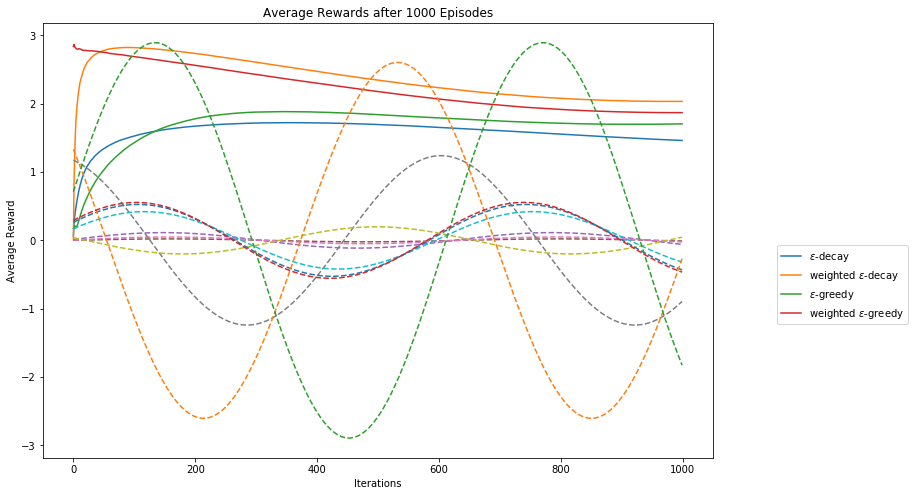

In [11]:
k = 10
iters = 1000
# Initialize bandits
ns_eps_decay = nonstationary_bandit(k, 1, 'decay', iters)
ns_eps_decay_weighted = nonstationary_bandit(
    k, 0.1, 'decay', iters, c=ns_eps_decay.c)
ns_eps_greedy = nonstationary_bandit(
    k, 1, 0.1, iters, c=ns_eps_decay.c)
ns_eps_greedy_weighted = nonstationary_bandit(
    k, 0.1, 0.1, iters, c=ns_eps_decay.c)
 
ns_eps_decay_rewards = np.zeros(iters)
ns_eps_decay_w_rewards = np.zeros(iters)
ns_eps_greedy_rewards = np.zeros(iters)
ns_eps_greedy_w_rewards = np.zeros(iters)
 
episodes = 1000
# Run experiments
for i in range(episodes):
    # Reset counts and rewards
    ns_eps_decay.reset()
    ns_eps_decay_weighted.reset()
    ns_eps_greedy.reset()
    ns_eps_greedy_weighted.reset()
     
    # Run experiments
    ns_eps_decay.run()
    ns_eps_decay_weighted.run()
    ns_eps_greedy.run()
    ns_eps_greedy_weighted.run()
     
    # Update long-term averages
    ns_eps_decay_rewards = ns_eps_decay_rewards + (
        ns_eps_decay.reward - ns_eps_decay_rewards) / (i + 1)
    ns_eps_decay_w_rewards = ns_eps_decay_w_rewards + (
        ns_eps_decay_weighted.reward -
        ns_eps_decay_w_rewards) / (i + 1)
    ns_eps_greedy_rewards = ns_eps_greedy_rewards + (
        ns_eps_greedy.reward - ns_eps_greedy_rewards) / (i + 1)
    ns_eps_greedy_w_rewards = ns_eps_greedy_w_rewards + (
        ns_eps_greedy_weighted.reward -
        ns_eps_greedy_w_rewards) / (i + 1)
     
x = np.arange(iters) * np.pi / iters
plt.figure(figsize=(12,8))
plt.plot(ns_eps_decay_rewards, 
    label=r"$\epsilon$-decay")
plt.plot(ns_eps_decay_w_rewards, 
    label=r"weighted $\epsilon$-decay")
plt.plot(ns_eps_greedy_rewards, 
    label=r"$\epsilon$-greedy")
plt.plot(ns_eps_greedy_w_rewards, 
    label=r"weighted $\epsilon$-greedy")
for c in ns_eps_decay.c:
    plt.plot(c * np.sin(x * np.pi + c), '--')
 
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards after "
          + str(episodes) + " Episodes")
plt.show()